In [1]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re

In [2]:
# 법령 XML 상세조회 (시행기준. target=eflaw)

#기본 url
url_base = " http://www.law.go.kr/DRF/lawService.do"

#조회 url 세부 설정
user_id = 'bmsong' #open API ID (bmsong@kau.ac.kr의 아이디 부분)
target = "eflaw" #법령 조회시
MST = "218289" #ID 또는 MST #산업안전보건법 MST 218289
#ID = "001766" 
            #ID 산업안전보건법 법령ID 001766 (설명에는 ID로 조회하면 현행법령이 조회된다는데, 
            #target을 eflaw로 하면 ID로 요청해도, MST로 요청해도 같은 것 같다.
Type = "XML" #출력 형태 : HTML 또는 XML

url_sub = "?" +\
        "OC=" + user_id +\
        "&target=" + target +\
        "&MST=" + MST +\
        "&type=" + Type

#최종 url
url = url_base + url_sub

print(url)

response = requests.get(url)

#(1) response.text 사용하는 방법
#soup = BeautifulSoup(response.text.encode('utf-8'), 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)

#(2) response.content 사용하는 방법
soup = BeautifulSoup(response.content, 'lxml-xml') #lxml-xml -> lxml 추가 설치 필요(Beautifulsoup과 별도로 설치)


# soup

 http://www.law.go.kr/DRF/lawService.do?OC=bmsong&target=eflaw&MST=218289&type=XML


In [3]:
lc_basic_df = pd.DataFrame() #DataFrame for Law Content 

data = soup.find('법령ID') #MST 정보
lc_basic_df['법령ID'] = [data.get_text()]

data = soup.find('법종구분') 
lc_basic_df['법종구분']= [data.get_text()]

data = soup.find('법령명_한글') 
lc_basic_df['법령명']= [data.get_text()]

data = soup.find('시행일자')
lc_basic_df['시행일자'] = [data.get_text()]

data = soup.find('공포일자') 
lc_basic_df['공포일자']= [data.get_text()]

data = soup.find('소관부처') 
lc_basic_df['소관부처']= [data.get_text()]

lc_basic_df

,법령ID,법종구분,법령명,시행일자,공포일자,소관부처
0,001766,법률,산업안전보건법,20210116,20200526,고용노동부


In [4]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)

#         if i.find("항내용"):
#             for j in i.find_all("항내용"):
#                 detail["항문내용"] = j.get_text().strip()
#                 df_info = df_info.append(detail,ignore_index = True)
#                 if i.find("호내용"):
#                     for k in i.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info.head(30)

In [5]:
# data = soup.find_all('조문단위')
# df_info = pd.DataFrame()
# info = []
# for i in data:
#     detail = {}
#     detail["index"] = np.nan
#     detail["조문제목"] = np.nan
#     detail["조문내용"] = np.nan
#     detail["항문내용"] = np.nan
#     detail["호문내용"] = np.nan
#     if i.find("조문여부").get_text() == "조문":
#         조문제목 = i.find("조문내용").get_text().strip().split(")")[0]+")"
#         detail["조문제목"] = 조문제목
#         if i.find("조문내용"):
#             조문내용 = i.find("조문내용").get_text().strip()[len(조문제목):-1].strip()
#             detail["조문내용"] = 조문내용
        
#         df_info = df_info.append(detail,ignore_index = True)
        
#         if i.find("항"):
#             for j in i.find_all("항"):
#                 if j.find("항내용"):
#                     detail["항문내용"] = j.항내용.get_text().strip()
#                     df_info = df_info.append(detail,ignore_index = True)
#                 if j.find("호내용"):
#                     for k in j.find_all("호내용"):
#                         detail["호문내용"] = k.get_text().strip()
#                         df_info = df_info.append(detail,ignore_index = True)
#                 detail["호문내용"] = np.nan
# df_info = df_info[["조문제목","조문내용","항문내용","호문내용"]]
# df_info

In [6]:
data = soup.find_all('조문단위')
df_info = pd.DataFrame()
info = []
for i in data:
    info_str = ""
    if i.find("조문여부").get_text() == "조문":
        info_str += i.조문내용.get_text().strip()
        if i.항:
            hang_nums = i.find_all("항번호")
            ho_nums = i.find_all("호번호")
            for idx, p in enumerate(i.find_all("호내용")):
                info_str += p.get_text().split(ho_nums[idx].get_text())[1].strip()
            for hang_idx, k in enumerate(i.find_all("항내용")):
                info_str += k.get_text().strip().split(hang_nums[hang_idx].get_text())[1].strip()
                for ho_idx ,j in enumerate(i.find_all("호내용")):
                    info_str += j.get_text().strip().split(ho_nums[ho_idx].get_text())[1].strip()
        info.append(info_str)
df_info["조내용"] = info
df_info

,조내용
0,제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2,"제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업..."
3,제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4,제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
...,...
172,제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173,제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174,"제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ..."
175,제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...


In [7]:
df_info.to_excel('산업안전보건법.xlsx',index = False)

# NLP(자연어 처리)



https://konlpy-ko.readthedocs.io/ko/v0.4.4/install/#id1

(konlpy를 사용하기위한 패키지를 다운받는 매뉴얼 입니다)


In [8]:
posts = df_info.get("조내용")
posts

0      제1조(목적) 이 법은 산업 안전 및 보건에 관한 기준을 확립하고 그 책임의 소재를...
1      제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다. <개정 2020.5.2...
2      제3조(적용 범위) 이 법은 모든 사업에 적용한다. 다만, 유해ㆍ위험의 정도, 사업...
3      제4조(정부의 책무)산업 안전 및 보건 정책의 수립 및 집행산업재해 예방 지원 및 ...
4      제5조(사업주 등의 의무)이 법과 이 법에 따른 명령으로 정하는 산업재해 예방을 위...
                             ...                        
172    제171조(벌칙) 다음 각 호의 어느 하나에 해당하는 자는 1천만원 이하의 벌금에 ...
173    제172조(벌칙) 제64조제1항 또는 제2항을 위반한 자는 500만원 이하의 벌금에...
174    제173조(양벌규정) 법인의 대표자나 법인 또는 개인의 대리인, 사용인, 그 밖의 ...
175    제174조(형벌과 수강명령 등의 병과)안전 및 보건에 관한 교육그 밖에 산업재해 예...
176    제175조(과태료)제119조제2항에 따라 기관석면조사를 하지 아니하고 건축물 또는 ...
Name: 조내용, Length: 177, dtype: object

In [9]:
from konlpy.tag import Mecab
tagger = Mecab()

In [10]:
# 불용어 리스트
# 불용어, 불필요 단어 제거
stop_words_df = pd.read_excel("stopwords.xlsx")
stop_words_df

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
674,영
675,조
676,항
677,등


In [11]:
# 명사부분 추출
nouns = []
for post in posts:
    for noun in tagger.nouns(post):
        if noun not in list(stop_words_df.get("불용어")):
            nouns.append(noun)
nouns[0:10]

['목적', '법', '산업', '안전', '보건', '기준', '확립', '책임', '소재', '산업']

In [12]:
words = []
for post in posts:
    words.extend(tagger.pos(post))
words[0:10]

[('제', 'XPN'),
 ('1', 'SN'),
 ('조', 'NNG'),
 ('(', 'SSO'),
 ('목적', 'NNG'),
 (')', 'SSC'),
 ('이', 'JKS'),
 ('법', 'NNG'),
 ('은', 'JX'),
 ('산업', 'NNG')]

In [13]:
# 동사 추출
verbs=[]
for word in words:
    if word[1]=='VV':
        verbs.append(word[0]+'다')
verbs[0:10]

['하다', '의하다', '인하다', '걸리다', '정하다', '하다', '맡기다', '받다', '받다', '받다']

In [14]:
# 형용사 추출
adjective=[]
for word in words:
    if word[1]=='VA':
        adjective.append(word[0]+'다')
adjective[0:10]

['같다', '심하다', '있다', '없다', '같다', '같다', '같다', '같다', '같다', '없다']

In [15]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 20
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns))
top_nouns
# print(len(counted_nouns))

{'조제': 1533,
 '안전': 1016,
 '경우': 907,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262,
 '노동부': 261,
 '밖': 255,
 '자료': 255}

In [16]:
!pip install wordcloud

In [17]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", font_path='./font/NanumBarunGothic.ttf')
wc.generate_from_frequencies(top_nouns)

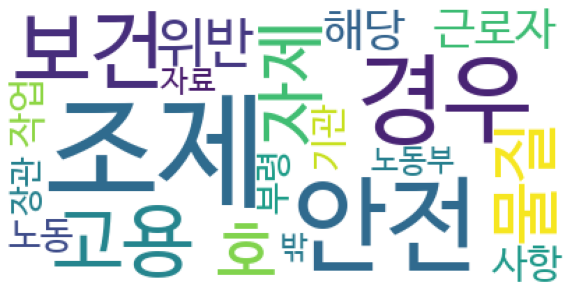

In [18]:
# 많이 나타나는 단어일수록 크게 나타남
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

# TfidfVectorizer

 TF(Term Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수

DF(Document Frequency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.

IDF(Inverse Document Frequency) : DF에 역수를 취해(inverse) 구함

TF-IDF : TF와 IDF를 곱한 값. 즉 TF가 높고, DF가 낮을수록 값이 커지는 것을 이용하는 것입니다.

해당 단위(문장) 안에서는 많이 등장하지만, 다른 문서들까지 전체에서는 적게 사용될수록, 분별력 있는 특징이란 것입니다.

In [19]:
# 자주 등장한 명사 20 개 기준
from sklearn.feature_extraction.text import TfidfVectorizer
tfidv = TfidfVectorizer(sublinear_tf = True).fit(top_nouns)
tfidv.transform(posts).toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.76749457, ..., 0.        , 0.        ,
        0.45329466],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.62791376, 0.        , 0.        , ..., 0.        , 0.        ,
        0.77828292],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.45450839, ..., 0.        , 0.        ,
        0.61665743]])

In [20]:
# 아예 등장하지 않는다면 0,
# 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것
# 작다면 그다지 가치가 없다고 판단이 가능
pd.DataFrame(tfidv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.0,0.767495,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.453295,0.0,0.0,0.453295
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.634925,0.0,0.000000,0.772574,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.0,0.386495,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.922291,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000
173,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
174,0.627914,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.778283
175,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.498305,0.867002,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000


In [42]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(posts)
sorted(tfidf_vectorizer.vocabulary_.items())

[('100분의', 0),
 ('10시부터', 1),
 ('10억원', 2),
 ('1까지', 3),
 ('1년', 4),
 ('1년의', 5),
 ('1년이', 6),
 ('1억원', 7),
 ('1일', 8),
 ('1주', 9),
 ('1천500만원', 10),
 ('1천만원', 11),
 ('200시간의', 12),
 ('2020', 13),
 ('26', 14),
 ('2개', 15),
 ('2년', 16),
 ('2년으로', 17),
 ('2년을', 18),
 ('2년이', 19),
 ('2분의', 20),
 ('300만원', 21),
 ('30년', 22),
 ('31', 23),
 ('34시간을', 24),
 ('3년', 25),
 ('3년의', 26),
 ('3일', 27),
 ('3천만원', 28),
 ('500만원', 29),
 ('5년', 30),
 ('5년간', 31),
 ('5년마다', 32),
 ('5년으로', 33),
 ('5천만원', 34),
 ('60개월을', 35),
 ('6개월', 36),
 ('6시간', 37),
 ('6시까지', 38),
 ('6의', 39),
 ('7년', 40),
 ('fume', 41),
 ('mist', 42),
 ('ㆍ미스트', 43),
 ('ㆍ산소결핍ㆍ병원체', 44),
 ('ㆍ제2항', 45),
 ('ㆍ제2항을', 46),
 ('使用年限', 47),
 ('倂科', 48),
 ('共謀', 49),
 ('動力', 50),
 ('危害', 51),
 ('實刑', 52),
 ('敎唆', 53),
 ('疫學調査', 54),
 ('精密工作', 55),
 ('計上', 56),
 ('計測監視', 57),
 ('試料', 58),
 ('財源', 59),
 ('가공', 60),
 ('가능하지', 61),
 ('가능한', 62),
 ('가동해서는', 63),
 ('가맹본부', 64),
 ('가맹본부는', 65),
 ('가맹본부의', 66),
 ('가맹사업거래의', 67),
 ('가맹점사업자에게', 68),
 ('가맹

In [22]:
tfidfv = TfidfVectorizer().fit_transform(posts)
tfidfv.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.11042345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
from konlpy.tag import Okt
okt = Okt()

oo = okt.pos(posts[0],
        norm=True,   # 정규화(normalization)
        stem=True    # 어간추출(stemming)
        )
print(oo)

[('제', 'Noun'), ('1조', 'Number'), ('(', 'Punctuation'), ('목적', 'Noun'), (')', 'Punctuation'), ('이', 'Noun'), ('법', 'Noun'), ('은', 'Josa'), ('산업', 'Noun'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('에', 'Josa'), ('관', 'Noun'), ('한', 'Josa'), ('기준', 'Noun'), ('을', 'Josa'), ('확립', 'Noun'), ('하고', 'Josa'), ('그', 'Noun'), ('책임', 'Noun'), ('의', 'Josa'), ('소재', 'Noun'), ('를', 'Josa'), ('명확하다', 'Adjective'), ('하다', 'Verb'), ('산업', 'Noun'), ('재해', 'Noun'), ('를', 'Josa'), ('예방', 'Noun'), ('하고', 'Josa'), ('쾌적하다', 'Adjective'), ('작업', 'Noun'), ('환경', 'Noun'), ('을', 'Josa'), ('조', 'Modifier'), ('성함', 'Noun'), ('으로써', 'Josa'), ('노무', 'Noun'), ('를', 'Josa'), ('제공', 'Noun'), ('하다', 'Verb'), ('사람', 'Noun'), ('의', 'Josa'), ('안전', 'Noun'), ('및', 'Noun'), ('보건', 'Noun'), ('을', 'Josa'), ('유지', 'Noun'), ('ㆍ', 'Foreign'), ('증진', 'Noun'), ('함', 'Noun'), ('을', 'Josa'), ('목적', 'Noun'), ('으로', 'Josa'), ('하다', 'Verb'), ('.', 'Punctuation'), ('<', 'Punctuation'), ('개정', 'Noun'), ('2020.5', 'Number'), ('.', '

In [24]:
def tokenizer(raw_texts, pos=["Noun","Alpha","Verb","Number"], stopword=[]):
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word not in stopword]
    return(o)

tokenizer(posts[0])

['1조',
 '목적',
 '산업',
 '안전',
 '보건',
 '기준',
 '확립',
 '책임',
 '소재',
 '하다',
 '산업',
 '재해',
 '예방',
 '작업',
 '환경',
 '성함',
 '노무',
 '제공',
 '하다',
 '사람',
 '안전',
 '보건',
 '유지',
 '증진',
 '목적',
 '하다',
 '개정',
 '2020.5',
 '26']

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer(
    tokenizer=tokenizer, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf=True    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.0726995, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)
#[[1.27771711]]
print(cosine_similarity(X[1], X[2]))#, X)
# [[0.1837195]]

[[1.27771711]]
[[0.1837195]]


# Euclidean Distance(Tfid)

In [27]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [28]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,1.284722,1.402257,1.194652,1.258394,1.310826,1.339240,1.367123,1.301529,1.330151,...,1.350656,1.391792,1.385381,1.372706,1.400526,1.384833,1.406531,1.406310,1.332902,1.367737
1,1.284722,0.000000,1.277717,1.330498,1.219381,1.311782,1.325861,1.352317,1.353467,1.246910,...,1.344297,1.386616,1.359085,1.353565,1.391598,1.369753,1.402156,1.377762,1.357085,1.301576
2,1.402257,1.277717,0.000000,1.407156,1.352597,1.386084,1.399560,1.375029,1.397072,1.343015,...,1.384538,1.386080,1.396412,1.397115,1.395523,1.394959,1.393091,1.390193,1.388164,1.387718
3,1.194652,1.330498,1.407156,0.000000,1.315622,1.257177,1.328272,1.334694,1.278987,1.351194,...,1.391132,1.399428,1.368984,1.374065,1.373025,1.372538,1.407445,1.398298,1.318730,1.357761
4,1.258394,1.219381,1.352597,1.315622,0.000000,1.204163,1.363013,1.345354,1.326436,1.313842,...,1.361678,1.361715,1.359643,1.354877,1.372193,1.337776,1.391616,1.387178,1.341395,1.306347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,1.384833,1.369753,1.394959,1.372538,1.337776,1.351838,1.389783,1.395538,1.401953,1.360448,...,1.212710,1.119891,1.185473,1.174835,1.316040,0.000000,1.242344,1.337556,1.284171,1.210152
173,1.406531,1.402156,1.393091,1.407445,1.391616,1.403984,1.406662,1.406359,1.406892,1.379290,...,1.262151,1.266491,1.312594,1.302037,1.247271,1.242344,0.000000,1.249267,1.378951,1.374109
174,1.406310,1.377762,1.390193,1.398298,1.387178,1.384799,1.400880,1.355333,1.404380,1.393063,...,1.306468,1.313202,1.351724,1.357423,1.346644,1.337556,1.249267,0.000000,1.357176,1.378577
175,1.332902,1.357085,1.388164,1.318730,1.341395,1.314363,1.347788,1.363368,1.336151,1.333064,...,1.194374,1.218019,1.279519,1.297484,1.067238,1.284171,1.378951,1.357176,0.000000,1.329215


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


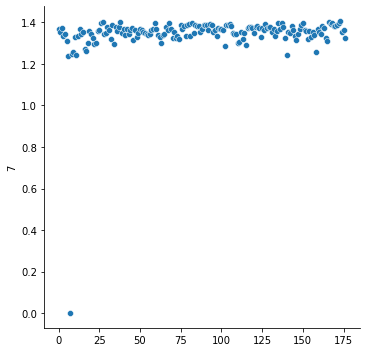

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
x = [i for i in range(len(df_info))]
jo = 8
y_euclidean = euclidean_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 2조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.show()


In [30]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:10]

[(8, 0.0),
 (7, 1.24014661136316),
 (141, 1.2404008803838469),
 (12, 1.242192005734461),
 (9, 1.248024204789678),
 (159, 1.2549777162393492),
 (10, 1.2556130803061363),
 (18, 1.2615386170299787),
 (17, 1.2726151189310564),
 (103, 1.286027722244149)]

# Cosine Similarity(Tfid)

In [31]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [32]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.174745,0.016837,0.286403,0.208222,0.140868,0.103218,0.065487,0.153011,0.115349,...,0.087864,0.031458,0.040360,0.057839,0.019264,0.041119,0.010835,0.011146,0.111686,0.064648
1,0.174745,1.000000,0.183719,0.114888,0.256555,0.139614,0.121046,0.085619,0.084063,0.222608,...,0.096433,0.038648,0.076444,0.083931,0.031727,0.061888,0.016980,0.050886,0.079160,0.152950
2,0.016837,0.183719,1.000000,0.009956,0.085241,0.039386,0.020616,0.054648,0.024095,0.098155,...,0.041527,0.039392,0.025017,0.024035,0.026257,0.027044,0.029649,0.033682,0.036500,0.037120
3,0.286403,0.114888,0.009956,1.000000,0.134570,0.209754,0.117846,0.109296,0.182097,0.087138,...,0.032376,0.020800,0.062941,0.055973,0.057401,0.058070,0.009550,0.022381,0.130476,0.078243
4,0.208222,0.256555,0.085241,0.134570,1.000000,0.274996,0.071098,0.095012,0.120283,0.136910,...,0.072917,0.072866,0.075686,0.082154,0.058544,0.105177,0.031702,0.037868,0.100330,0.146729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.041119,0.061888,0.027044,0.058070,0.105177,0.086266,0.034252,0.026237,0.017264,0.074590,...,0.264667,0.372922,0.297327,0.309882,0.134020,1.000000,0.228291,0.105472,0.175452,0.267767
173,0.010835,0.016980,0.029649,0.009550,0.031702,0.014414,0.010651,0.011078,0.010327,0.048779,...,0.203488,0.198000,0.138548,0.152350,0.222158,0.228291,1.000000,0.219666,0.049247,0.055912
174,0.011146,0.050886,0.033682,0.022381,0.037868,0.041166,0.018768,0.081536,0.013859,0.029687,...,0.146571,0.137750,0.086421,0.078702,0.093274,0.105472,0.219666,1.000000,0.079037,0.049762
175,0.111686,0.079160,0.036500,0.130476,0.100330,0.136225,0.091734,0.070614,0.107351,0.111471,...,0.286735,0.258215,0.181416,0.158268,0.430501,0.175452,0.049247,0.079037,1.000000,0.116593


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


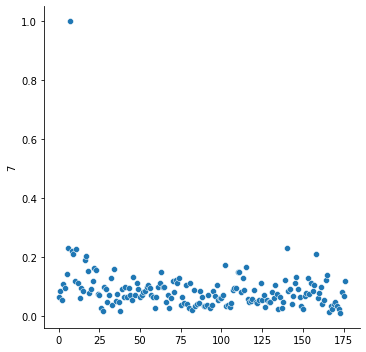

In [33]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 2조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [34]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 일치한 값이 도출됨
# [(8, 0.0),
#  (7, 1.24014661136316),
#  (141, 1.2404008803838469),
#  (12, 1.242192005734461),
#  (9, 1.248024204789678),
#  (159, 1.2549777162393492),
#  (10, 1.2556130803061363),
#  (18, 1.2615386170299787),
#  (17, 1.2726151189310564),
#  (103, 1.286027722244149)]

[(8, 1.0000000000000002),
 (7, 0.23101819116223565),
 (141, 0.23070282797148908),
 (12, 0.22847951044469875),
 (9, 0.22121779212954643),
 (159, 0.21251546587133402),
 (10, 0.21171789628206825),
 (18, 0.20426015887104457),
 (17, 0.19022537953404692),
 (103, 0.1730663488097632)]

# CountVectorizer(Tfid)
가장 단순한 특징으로, 텍스트에서 단위별 등장횟수를 카운팅하여 수치벡터화 하는 것

단위는 문서 단위, 문장 단위, 단어 단위... 가 될 수 있음

가장 많이 사용되는 것은 단어단위의 카운팅

In [35]:
# 빈도높은 상위 20개 명사들로 CountVectorizing
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer().fit(top_nouns)
countv.transform(posts).toarray()
top_nouns

{'조제': 1533,
 '안전': 1016,
 '경우': 907,
 '보건': 671,
 '고용': 571,
 '자제': 446,
 '물질': 420,
 '호': 398,
 '위반': 382,
 '근로자': 353,
 '해당': 353,
 '사항': 347,
 '작업': 342,
 '기관': 320,
 '노동': 302,
 '부령': 301,
 '장관': 262,
 '노동부': 261,
 '밖': 255,
 '자료': 255}

In [36]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,9,0,0,18,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
174,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
175,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,0,0


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
countv = CountVectorizer(stop_words = list(stop_words_df.get("불용어")))
sp_mat = countv.fit_transform(posts)
# 희소행렬을 np array로
sp_mat.toarray()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가서', '같은', '것과', '결과에', '결론을', '관계가', '관련이', '그런', '그럼에도', '그렇게', '그에', '그치지', '김에', '까닭에', '낫다', '년도', '논하지', '누가', '다시', '달려', '대로', '대해', '되는', '되다', '되어', '들면', '들자면', '듯하다', '따르는', '따름이다', '따지지', '때가', '만은', '만이', '많은', '말하면', '말할것도', '몰라도', '몰랏다', '못하다', '못하다하기보다는', '미치다', '바꾸어서', '바꿔', '밖에', '방면으로', '보면', '보아', '부류의', '비길수', '비추어', '뿐만', '사람들', '상대적으로', '생각이다', '서술한바와같이', '쓰여', '아니다', '아니라', '안다', '안된다', '않고', '않기', '않는다면', '않다', '않다면', '않도록', '않으면', '알겠는가', '어쩔수', '없고', '없다', '예를', '외에', '요만한', '우에', '위에서', '이렇게', '이로', '이르다', '이와', '이유는', '인하여', '임에', '점에서', '정도에', '정도의', '종합한것과같이', '주저하지', '줄은', '지경이다', '틀림없다', '편이', '하고', '하기', '하기만', '하는', '하는것만', '하는것이', '하다', '하면', '하지', '한하다', '할수록', '함으로써', '해도', '해서는', '형식으로', '힘이'] not in stop_words.
  warnings.warn('Your stop_words may

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [38]:
# 단어: 정수인덱스로 구성된 딕셔너리
countv.vocabulary_

{'제1조': 2896,
 '목적': 913,
 '법은': 1047,
 '산업': 1373,
 '안전': 1766,
 '보건에': 1092,
 '기준을': 652,
 '확립하고': 3878,
 '책임의': 3525,
 '소재를': 1562,
 '명확하게': 908,
 '하여': 3743,
 '산업재해를': 1392,
 '예방하고': 2001,
 '쾌적한': 3608,
 '작업환경을': 2538,
 '조성함으로써': 3263,
 '노무를': 693,
 '제공하는': 3187,
 '사람의': 1234,
 '보건을': 1093,
 '유지ㆍ증진함을': 2125,
 '목적으로': 917,
 '한다': 3750,
 '개정': 110,
 '2020': 13,
 '26': 14,
 '제2조': 2932,
 '정의': 2680,
 '법에서': 1046,
 '사용하는': 1311,
 '용어의': 2051,
 '뜻은': 860,
 '다음과': 718,
 '산업재해': 1390,
 '사람이': 1235,
 '업무에': 1908,
 '관계되는': 439,
 '건설물ㆍ설비ㆍ원재료ㆍ가스ㆍ증기ㆍ분진': 183,
 '등에': 841,
 '의하거나': 2205,
 '작업': 2496,
 '또는': 859,
 '밖의': 953,
 '업무로': 1896,
 '인하여': 2293,
 '사망': 1248,
 '부상하거나': 1177,
 '질병에': 3472,
 '걸리는': 204,
 '것을': 231,
 '말한다': 868,
 '중대재해': 3333,
 '재해': 2580,
 '정도가': 2662,
 '심하거나': 1747,
 '다수의': 716,
 '재해자가': 2586,
 '발생한': 984,
 '경우로서': 282,
 '고용노동부령으로': 370,
 '정하는': 2687,
 '재해를': 2583,
 '근로자': 557,
 '근로기준법': 552,
 '제2조제1항제1호에': 2934,
 '따른': 850,
 '근로자를': 570,
 '사업주': 1283,
 '사용하여': 1313,
 '사업을':

In [39]:
pd.DataFrame(countv.transform(posts).toarray())

,0,1,2,3,4,5,6,7,8,9,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
vectorize = CountVectorizer(
    tokenizer=tokenizer, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df=1,            # 단어가 출현하는 최소 문서의 개수
)

X = vectorize.fit_transform(posts)
X.toarray() 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0]])

In [47]:
# 2번째와 3번째 문서(코사인 값)
print(euclidean_distances(X[1], X[2]))#, X)

print(cosine_similarity(X[1], X[2]))#, X)

[[35.51056181]]
[[0.6074051]]


# Euclidean Distance(CountVectorizer)

In [48]:
# 모든 조에 해당하는 euclidean distance 를 계산
euclidean_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(euclidean_distances(X[x], X[y])[0][0])
    euclidean_result.append(tmp)
# euclidean_result

In [49]:
# 모든 조에 해당하는 euclidean distance 결과 값을
# DataFrame 형태로 변환
euclidean_result_df = pd.DataFrame(euclidean_result)
euclidean_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,0.000000,37.934153,10.198039,42.579338,35.902646,7.483315,9.899495,58.983048,12.000000,23.769729,...,12.409674,23.537205,23.086793,24.166092,12.083046,11.532563,6.782330,13.892444,45.847574,1022.000978
1,37.934153,0.000000,35.510562,52.516664,29.631065,36.891733,36.537652,52.038447,36.455452,27.459060,...,33.719431,32.787193,36.823905,31.160873,39.686270,35.440090,39.937451,34.928498,41.412558,998.922920
2,10.198039,35.510562,0.000000,46.184413,34.856850,10.000000,12.165525,57.280014,14.628739,22.472205,...,12.000000,21.954498,23.000000,22.891046,13.341664,11.789826,9.591663,13.527749,45.628938,1020.033333
3,42.579338,52.516664,46.184413,0.000000,48.207883,43.965896,43.347434,65.467549,41.048752,44.497191,...,46.076024,48.979588,46.754679,47.968740,46.529560,45.738387,46.314145,46.475800,49.969991,1012.695907
4,35.902646,29.631065,34.856850,48.207883,0.000000,34.336569,35.085610,50.019996,33.985291,29.698485,...,33.391616,33.271610,35.014283,31.796226,37.161808,33.882149,38.196859,34.351128,40.509258,1001.001998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11.532563,35.440090,11.789826,45.738387,33.882149,10.908712,12.922848,56.938563,15.198684,22.271057,...,10.440307,18.947295,20.297783,18.681542,13.674794,0.000000,10.908712,12.328828,43.508620,1015.411739
173,6.782330,39.937451,9.591663,46.314145,38.196859,7.483315,10.583005,60.506198,13.711309,25.514702,...,12.409674,24.083189,23.473389,24.939928,10.392305,10.908712,0.000000,13.527749,48.270074,1023.739225
174,13.892444,34.928498,13.527749,46.475800,34.351128,13.379088,14.730920,56.231664,16.763055,22.759613,...,12.922848,20.469489,21.863211,21.142375,15.459625,12.328828,13.527749,0.000000,43.897608,1016.582018
175,45.847574,41.412558,45.628938,49.969991,40.509258,45.055521,44.497191,56.648036,43.220366,38.483763,...,41.641326,38.000000,42.555846,39.012818,44.899889,43.508620,48.270074,43.897608,0.000000,995.384348


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


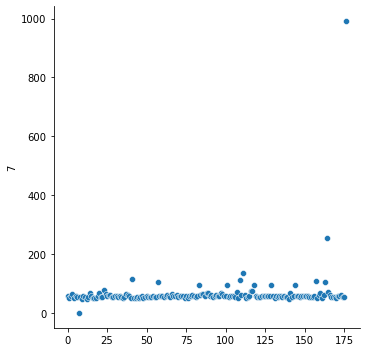

In [50]:
x = [i for i in range(len(df_info))]
jo = 8
y_euclidean = euclidean_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 8조와 다른 조들 간의euclidean distance 분포 시각화
sns.relplot(x,y_euclidean)
plt.show()

In [51]:
# euclidean distance 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_euclidean = euclidean_result_df[jo-1]
dic = {}
for i in range(len(y_euclidean)):
    dic[i+1] = y_euclidean[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1])[0:10]

[(8, 0.0),
 (13, 47.148700936505136),
 (10, 48.41487374764082),
 (141, 49.54795656734998),
 (5, 50.0199960015992),
 (159, 50.44799302251776),
 (18, 50.695167422546305),
 (132, 50.84289527554464),
 (17, 51.146847410177685),
 (36, 51.18593556827891)]

# Cosine Similarity(CountVectorizer)

In [52]:
cosine_result = []
for x in range(len(df_info)):
    tmp = []
    for y in range(len(df_info)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)

In [53]:
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df

,0,1,2,3,4,5,6,7,8,9,...,167,168,169,170,171,172,173,174,175,176
0,1.000000,0.476790,0.278710,0.636857,0.518026,0.431821,0.416030,0.362253,0.496548,0.477439,...,0.387541,0.336576,0.279097,0.398548,0.098689,0.332732,0.152499,0.288280,0.514804,0.426047
1,0.476790,1.000000,0.607405,0.278222,0.722862,0.570959,0.495601,0.538013,0.456017,0.743485,...,0.636660,0.590763,0.446458,0.641495,0.218492,0.553667,0.262595,0.546389,0.585270,0.648286
2,0.278710,0.607405,1.000000,0.133327,0.512132,0.355964,0.296099,0.450777,0.271831,0.538849,...,0.500878,0.480784,0.308300,0.487787,0.168964,0.426030,0.236914,0.419422,0.419621,0.485391
3,0.636857,0.278222,0.133327,1.000000,0.372267,0.406369,0.396909,0.281773,0.517125,0.355055,...,0.172160,0.164128,0.246231,0.220898,0.109457,0.187873,0.078931,0.152223,0.451430,0.281208
4,0.518026,0.722862,0.512132,0.372267,1.000000,0.669711,0.474491,0.576313,0.508344,0.645528,...,0.552035,0.528732,0.461344,0.581560,0.292633,0.544212,0.257343,0.481069,0.594425,0.623708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.332732,0.553667,0.426030,0.187873,0.544212,0.441305,0.347352,0.430307,0.309677,0.531866,...,0.664868,0.680239,0.537542,0.757930,0.279296,1.000000,0.447563,0.569918,0.547695,0.788183
173,0.152499,0.262595,0.236914,0.078931,0.257343,0.179787,0.156787,0.202050,0.144715,0.279988,...,0.423547,0.334405,0.249567,0.409953,0.277350,0.447563,1.000000,0.350070,0.231873,0.347392
174,0.288280,0.546389,0.419422,0.152223,0.481069,0.377627,0.329318,0.440448,0.288764,0.497205,...,0.565174,0.570342,0.442654,0.583916,0.265385,0.569918,0.350070,1.000000,0.477003,0.578475
175,0.514804,0.585270,0.419621,0.451430,0.594425,0.571059,0.502335,0.487008,0.527018,0.622570,...,0.637678,0.642847,0.491876,0.607037,0.463410,0.547695,0.231873,0.477003,1.000000,0.616589


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


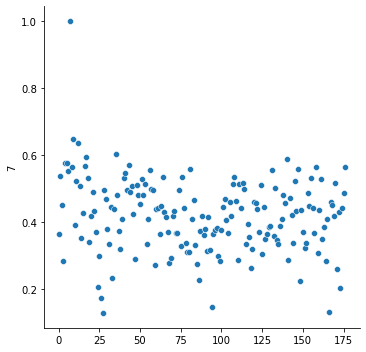

In [54]:
x = [i for i in range(len(df_info))]
y_cosine = cosine_result_df[jo-1]
# y = euclidean_result_df.loc[2]

# 2조와 다른 조들 간의 cosine simiarity 분포 시각화
sns.relplot(x,y_cosine)
plt.show()

In [55]:
# cosine similarity 값으로 
# 8조와 가장 비슷한 조를 찾기위한 과정
y_cosine = cosine_result_df[jo-1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:10]

# euclidean distance 를 이용한 값과 약간 상이한 도출됨
# [(8, 0.0),
#  (13, 47.148700936505136),
#  (10, 48.41487374764082),
#  (141, 49.54795656734998),
#  (5, 50.0199960015992),
#  (159, 50.44799302251776),
#  (18, 50.695167422546305),
#  (132, 50.84289527554464),
#  (17, 51.146847410177685),
#  (36, 51.18593556827891)]

[(8, 1.0000000000000002),
 (10, 0.6467509206755794),
 (13, 0.6365306246190017),
 (36, 0.6031264860167888),
 (18, 0.592889160709694),
 (141, 0.5873721916862898),
 (5, 0.5763132647219397),
 (6, 0.5743420023521153),
 (44, 0.568923895645734),
 (17, 0.5680918113915253)]